<a href="https://colab.research.google.com/github/StephHiyagon/Project_BI/blob/main/Proyecto_Grupal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalar los paquetes necesarios
install.packages("readxl")
install.packages("caret")
install.packages("randomForest")
install.packages("ggplot2")
install.packages("glmnet")




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [44]:
# Cargar las librerías necesarias
library(readxl)
library(caret)
library(randomForest)
library(ggplot2)
library(glmnet)
library(pROC)

In [3]:
#ubicación del archivo#
system("wget -O archivo.xlsx 'https://drive.usercontent.google.com/download?id=1gM9j2JwjLLVTa0gRDmj9Hj5dKwclHr0M'")

#leer la datos#
datos <- read_excel("/content/archivo.xlsx")
head(datos)

CustomerID,Title,FirstName,MiddleName,LastName,Suffix,AddressLine1,AddressLine2,City,StateProvinceName,⋯,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,NumberChildrenAtHome,TotalChildren,YearlyIncome,LastUpdated,BikeBuyer,AvgMonthSpend,BikeBuyerText
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<chr>,<chr>
21173,NULL,Chad,C,Yuan,NULL,7090 C. Mount Hood,NULL,Wollongong,New South Wales,⋯,M,1,3,0,1,81916,2017-03-06,1,50.97,YES
13249,NULL,Ryan,NULL,Perry,NULL,3651 Willow Lake Rd,NULL,Shawnee,British Columbia,⋯,M,1,2,1,2,81076,2017-03-06,1,53.11,YES
29350,NULL,Julia,NULL,Thompson,NULL,1774 Tice Valley Blvd.,NULL,West Covina,California,⋯,S,0,3,0,0,86387,2017-03-06,1,54.08,YES
13503,NULL,Theodore,NULL,Gomez,NULL,2103 Baldwin Dr,NULL,Liverpool,England,⋯,M,1,2,1,2,61481,2017-03-06,1,56.93,YES
22803,NULL,Marshall,J,Shan,NULL,Am Gallberg 234,NULL,Werne,Nordrhein-Westfalen,⋯,S,1,1,0,0,51804,2017-03-06,1,55.41,YES
22092,NULL,Andrea,NULL,Young,NULL,9384 Ashmount Way,NULL,Tacoma,Washington,⋯,M,1,2,2,2,61944,2017-03-06,1,49.31,YES


In [4]:
# Seleccionar las variables de interés y asegurar que AvgMonthSpend sea numérica

df <- datos[, c(
  "Occupation",
  "NumberChildrenAtHome",
  "MaritalStatus",
  "HomeOwnerFlag",
  "NumberCarsOwned",
  "TotalChildren",
  "YearlyIncome",
  "BikeBuyer",
  "AvgMonthSpend"
)]

df$Occupation <- as.factor(trimws(df$Occupation))
df$NumberChildrenAtHome <- as.integer(df$NumberChildrenAtHome)
df$MaritalStatus <- as.factor(trimws(df$MaritalStatus))
df$HomeOwnerFlag <- as.logical(df$HomeOwnerFlag)
df$NumberCarsOwned <- as.integer(df$NumberCarsOwned)
df$TotalChildren <- as.integer(df$TotalChildren)
df$BikeBuyer <- as.logical(df$BikeBuyer)
df$AvgMonthSpend <- as.numeric(df$AvgMonthSpend)

head(df)

Occupation,NumberChildrenAtHome,MaritalStatus,HomeOwnerFlag,NumberCarsOwned,TotalChildren,YearlyIncome,BikeBuyer,AvgMonthSpend
<fct>,<int>,<fct>,<lgl>,<int>,<int>,<dbl>,<lgl>,<dbl>
Clerical,0,M,TRUE,3,1,81916,TRUE,50.97
Clerical,1,M,TRUE,2,2,81076,TRUE,53.11
Clerical,0,S,FALSE,3,0,86387,TRUE,54.08
Skilled Manual,1,M,TRUE,2,2,61481,TRUE,56.93
Skilled Manual,0,S,TRUE,1,0,51804,TRUE,55.41
Skilled Manual,2,M,TRUE,2,2,61944,TRUE,49.31


In [12]:
columnas_factor = sapply(df, is.factor)

df_factor = df[, columnas_factor]

filtrado <- sapply(df_factor, function(columna) {
  any(columna == "-" | columna == "")
})

as.data.frame(filtrado)

,filtrado
,<lgl>
Occupation,FALSE
MaritalStatus,FALSE


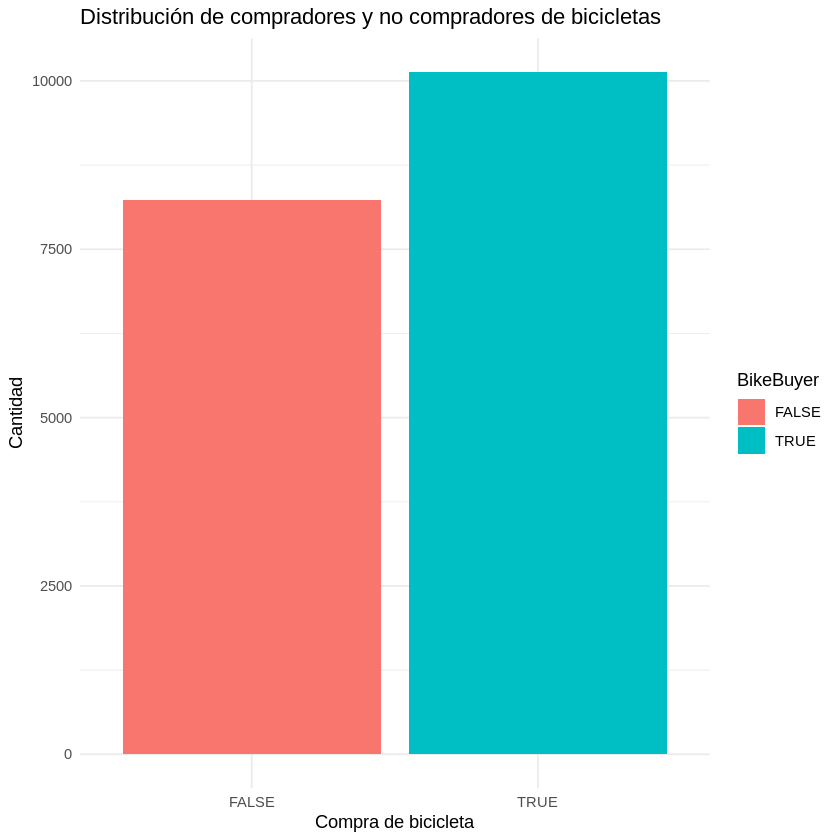

In [5]:
ggplot(df, aes(x = BikeBuyer)) +
  geom_bar(aes(fill = BikeBuyer)) +
  labs(title = "Distribución de compradores y no compradores de bicicletas",
       x = "Compra de bicicleta",
       y = "Cantidad") +
  theme_minimal()

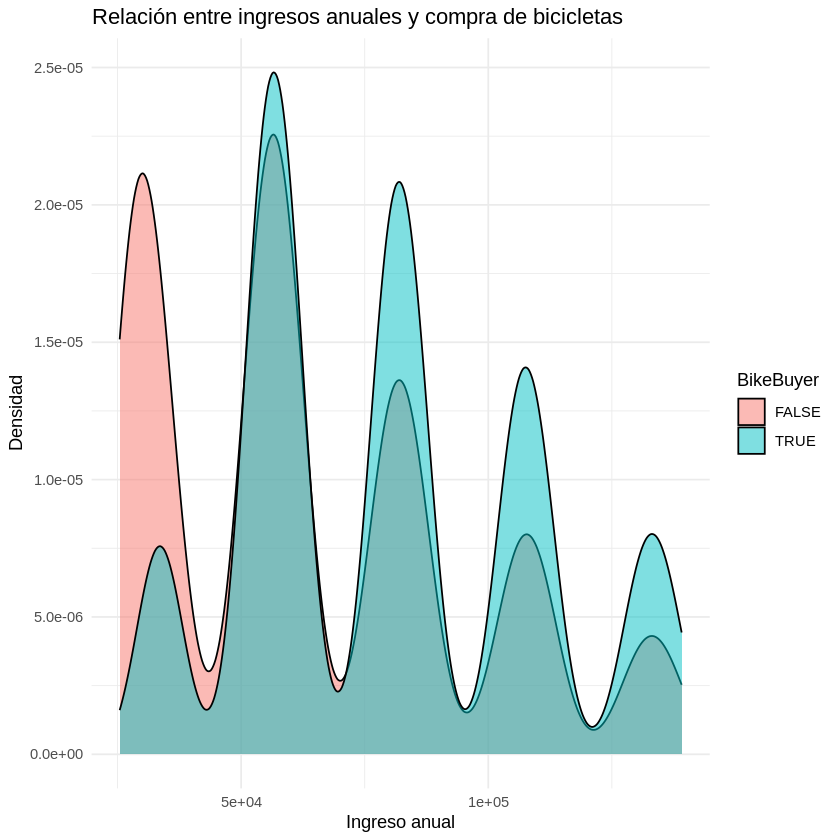

In [6]:
ggplot(df, aes(x = YearlyIncome, fill = BikeBuyer)) +
  geom_density(alpha = 0.5) +
  labs(title = "Relación entre ingresos anuales y compra de bicicletas",
       x = "Ingreso anual",
       y = "Densidad") +
  theme_minimal()

In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba (usando una muestra más pequeña para entrenamiento)

set.seed(123)
sampleIndex <- sample(1:nrow(df), 5000)  # Tomar una muestra de 5000 observaciones
dfSample <- df[sampleIndex, ]
trainIndex <- createDataPartition(dfSample$BikeBuyer, p = 0.8, list = FALSE)
dfTrain <- dfSample[trainIndex, ]
dfTest <- dfSample[-trainIndex, ]

In [13]:
# Estandarizar las variables numéricas
preProcValues <- preProcess(dfTrain, method = c("center", "scale"))
dfTrain <- predict(preProcValues, dfTrain)
dfTest <- predict(preProcValues, dfTest)


In [14]:
str(dfTrain)

tibble [4,001 × 9] (S3: tbl_df/tbl/data.frame)
 $ Occupation          : Factor w/ 5 levels "Clerical","Management",..: 5 5 5 3 1 4 1 4 1 2 ...
 $ NumberChildrenAtHome: num [1:4001] -0.596 1.139 1.139 -0.596 -0.596 ...
 $ MaritalStatus       : Factor w/ 2 levels "M","S": 2 1 1 2 2 2 1 2 2 1 ...
 $ HomeOwnerFlag       : logi [1:4001] FALSE TRUE TRUE FALSE FALSE TRUE ...
 $ NumberCarsOwned     : num [1:4001] 0.792 0.792 -0.295 -0.295 1.879 ...
 $ TotalChildren       : num [1:4001] -0.916 0.165 1.247 -0.916 -0.916 ...
 $ YearlyIncome        : num [1:4001] -0.571 -0.387 -0.523 -1.236 0.39 ...
 $ BikeBuyer           : logi [1:4001] TRUE TRUE TRUE FALSE FALSE FALSE ...
 $ AvgMonthSpend       : num [1:4001] 0.172 0.331 -0.14 -0.336 -0.007 ...


In [47]:
# Entrenar el modelo de regresión logística con regularización Lasso
dfTrain$BikeBuyer <- as.factor(dfTrain$BikeBuyer)
model <- train(BikeBuyer ~ ., data = dfTrain, method = "glmnet", family = "binomial")


In [26]:
# Evaluamos el modelo con los datos de prueba

predictions <- predict(model, newdata = dfTest)
conf_matrix <- confusionMatrix(as.factor(predictions), as.factor(dfTest$BikeBuyer))
conf_matrix


Confusion Matrix and Statistics

          Reference
Prediction FALSE TRUE
     FALSE   273  132
     TRUE    166  428
                                          
               Accuracy : 0.7017          
                 95% CI : (0.6723, 0.7299)
    No Information Rate : 0.5606          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.3894          
                                          
 Mcnemar's Test P-Value : 0.05592         
                                          
            Sensitivity : 0.6219          
            Specificity : 0.7643          
         Pos Pred Value : 0.6741          
         Neg Pred Value : 0.7205          
             Prevalence : 0.4394          
         Detection Rate : 0.2733          
   Detection Prevalence : 0.4054          
      Balanced Accuracy : 0.6931          
                                          
       'Positive' Class : FALSE           
                     

[1] "confusionMatrix"

Setting levels: control = FALSE, case = TRUE

Setting direction: controls < cases



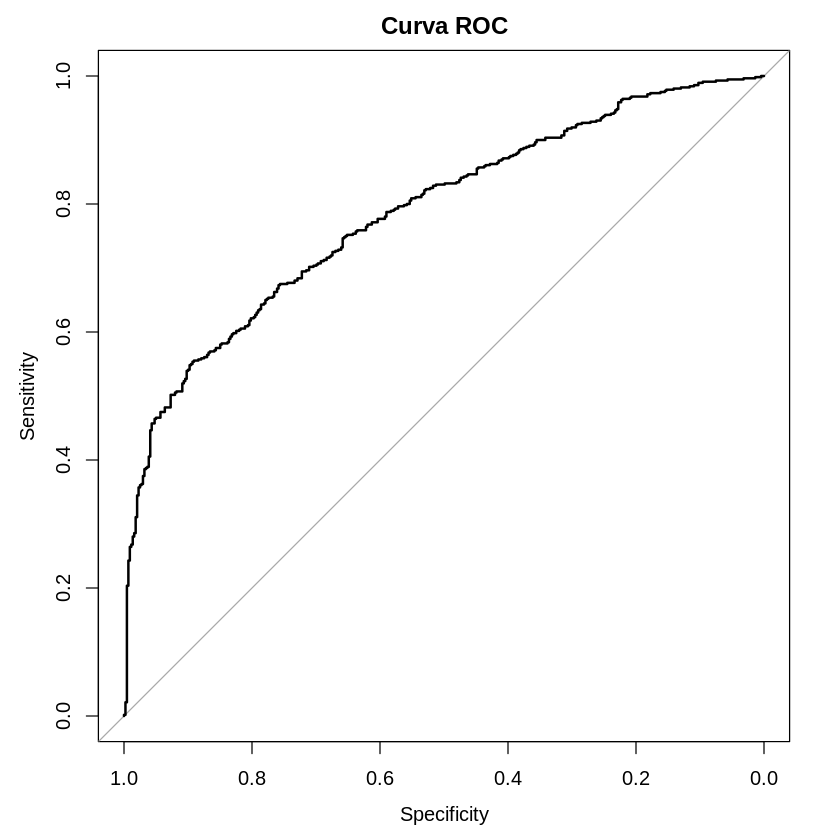

In [41]:
probabilities <- predict(model, newdata = dfTest, type = "prob")[,2]
roc_curve <- roc(dfTest$BikeBuyer, probabilities)
plot(roc_curve, main = "Curva ROC")

In [28]:
#convertir la tabla en dataframe
confusion_df <- as.data.frame(conf_matrix$table)
#cambiar los nombres
colnames(confusion_df) <- c("Actual", "Predicted", "Count")
confusion_df$Count <- confusion_df$Count / sum(confusion_df$Count) * 100


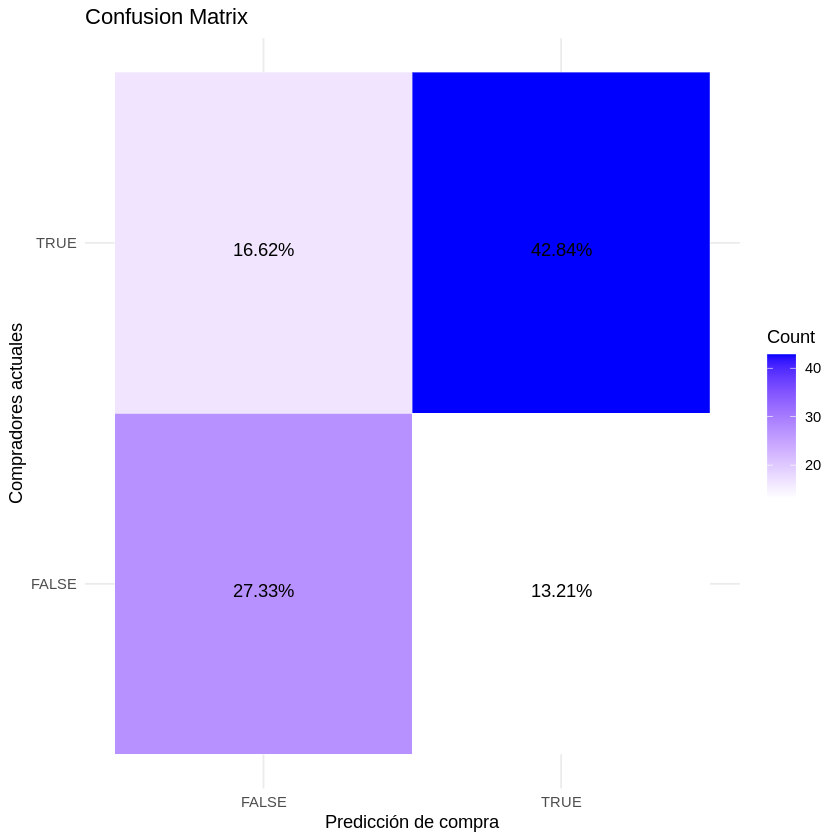

In [29]:
ggplot(data = confusion_df, aes(x = Predicted, y = Actual, fill = Count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = paste0(round(Count, 2), "%")), vjust = 1) +
  scale_fill_gradient(low = "white", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicción de compra", y = "Compradores actuales") +
  theme_minimal()

[1] TRUE
Levels: FALSE TRUE

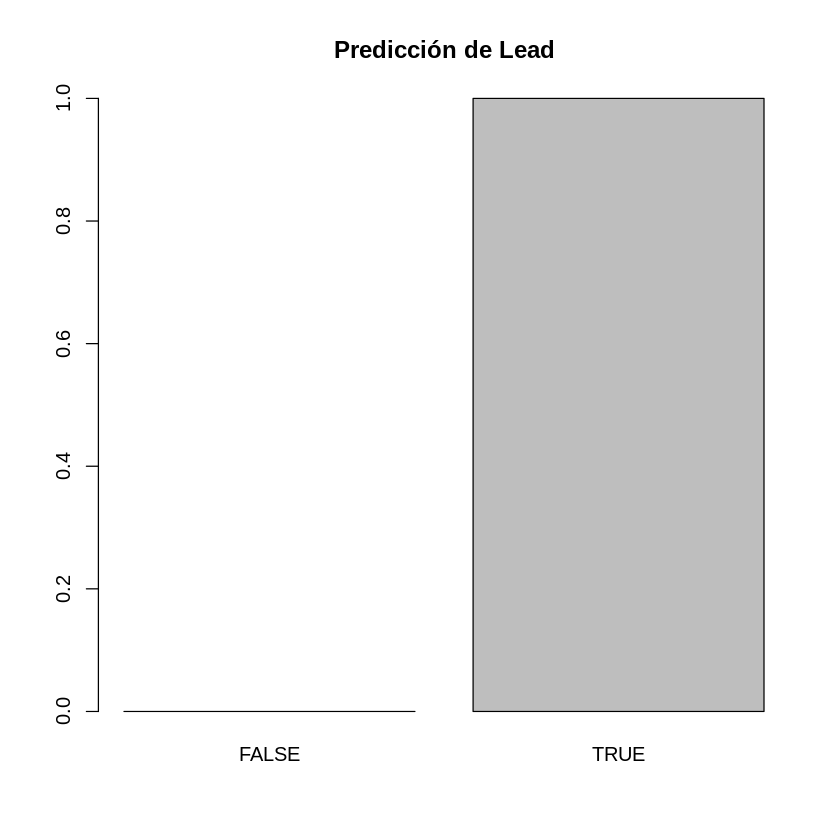

In [50]:
new_customer <- data.frame(YearlyIncome = 60000, Occupation = "Professional", MaritalStatus = "S", HomeOwnerFlag = TRUE, NumberCarsOwned = 1, NumberChildrenAtHome = 2, TotalChildren = 2, AvgMonthSpend = 100)
new_customer <- predict(preProcValues, new_customer)
prediction <- predict(model, new_customer)
prediction
plot(prediction, main = "Predicción de Lead")